In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors

eps = 1e-5
%matplotlib inline
matplotlib.rcParams["figure.facecolor"] = "white"
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["savefig.facecolor"] = "white"

dir_fig = lambda x: "figs/" + x

In [22]:
n = 10000
mu = np.array([0, 0])
sigma = np.array([[1, 0], [0, 1]])

data = np.random.multivariate_normal(mu, sigma, size=n)

In [23]:
def distance_r2(data, mu):
    distance = np.zeros(data.shape[0])
    for i in range(data.shape[0]):
        x = data[i, :]
        aux = np.power(x, 2) + np.power(mu, 2)
        if (np.abs(aux[0] - aux[1]) < eps):
            distance[i] = np.sqrt(np.power(x[0] - mu[0], 2) + np.power(x[1] - mu[1], 2))
        else:
            distance[i] = np.sqrt(aux[0]) + np.sqrt(aux[1])
    return distance

def distance_eucl(data, mu):
    diff = data - mu
    return np.sqrt(np.power(diff, 2).sum(-1))

def distance_p(p):
    def aux_distance(data, mu):
        diff = np.abs(data - mu)
        return np.power(np.power(diff, p).sum(-1), 1/p)
    def mahalanobis(data, mu, icov):
        diff = data - mu
        return np.sqrt((diff.dot(icov) * diff).sum(-1))
    if p == 0:
        return mahalanobis
    return aux_distance

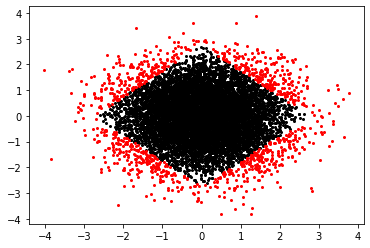

In [24]:
# Distances and percentile
distances = distance_r2(data, mu)
perc_90 = np.percentile(distances, 90)

# Data separation
data_small = data[distances <= perc_90, :]
data_big = data[distances > perc_90, :]

# Plotting
plt.scatter(data_small[:, 0], data_small[:, 1], color='k', s=4)
plt.scatter(data_big[:, 0], data_big[:, 1], color='r', s=4)
plt.savefig(dir_fig("4.pdf"), bbox_inches='tight')
plt.show()

In [25]:
def calculate_cost(distances, u):
    return distances.dot(u.T).sum()

def find_membership(data, k, dist, prototypes, args):
    u = np.zeros((k, data.shape[0]))
    distances = np.zeros((k, data.shape[0]))
    for j in range(k):
        distances[j, :] = dist(data, prototypes[j, :], *args)
    indexes_min = np.argmin(distances, axis=0)
    for j in range(u.shape[1]):
        u[:, j] = 0
        u[indexes_min[j], j] = 1

    return u

def k_means(data, k, dist, n_iter, args):
    # Random selection of k prototypes
    indexes = np.array(range(data.shape[0]))
    selection = np.random.choice(indexes, size=k, replace=False)
    prototypes = data[selection, :]

    for i in range(n_iter):
        # Find membership
        u = find_membership(data, k, dist, prototypes, args)

        # Update prototypes
        prototypes = np.divide(u.dot(data), np.reshape(u.sum(-1), (u.shape[0], 1)))

    return prototypes, find_membership(data, k, dist, prototypes, args)

def plot_clusters(proto, memberships, data, fig_title):
    color1 = plt.get_cmap('winter')
    color_norm = colors.Normalize(vmin=0, vmax=proto.shape[0] - 1)
    scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
    for j in range(proto.shape[0]):
        data_group = data[memberships[j, :] == 1, :]
        color = scalar_map.to_rgba(j)
        plt.scatter(data_group[:, 0], data_group[:, 1], color=color, s=4)
    plt.scatter(proto[:, 0], proto[:, 1], color='k', s=8)
    plt.savefig(dir_fig(fig_title), bbox_inches='tight')
    plt.clf()

In [26]:
k = 8
proto, memberships = k_means(data, k, distance_eucl, 100)

plot_clusters(proto, memberships, data, "5-example-k-8.pdf")

TypeError: k_means() missing 1 required positional argument: 'args'

In [27]:
mu1, mu2, mu3 = np.array([0, 0]), np.array([1, 1]), np.array([10, 10])

cov1 = np.array([[3, 0], [0, 1]])
cov2 = np.array([[2, 0], [0, 3]])
cov3 = np.array([[1.1, 0], [0, 2.2]])

data1 = np.random.multivariate_normal(mu1, cov1, size=3000)
data2 = np.random.multivariate_normal(mu2, cov2, size=3000)
data3 = np.random.multivariate_normal(mu3, cov3, size=3000)

mixture = np.concatenate((data1, data2, data3))

In [28]:
ps = [0, 1, 2]
protos, memberships = [], []
for p in ps:
    if p == 0:
        args = [np.linalg.inv(cov1)]
    else:
        args = []
    proto, memb = k_means(mixture, 3, distance_p(p), 100, args)
    protos.append(proto)
    memberships.append(memb)

for i in range(len(ps)):
    title = "5-{}-norm.pdf".format(ps[i])
    plot_clusters(protos[i], memberships[i], mixture, title)

<Figure size 432x288 with 0 Axes>

In [29]:
ps = [0, 1, 2]
protos, memberships = [], []
cov = np.cov(data.T)
for p in ps:
    if p == 0:
        args = [np.linalg.inv(cov)]
    else:
        args = []
    proto, memb = k_means(mixture, 3, distance_p(p), 100, args)
    protos.append(proto)
    memberships.append(memb)

for i in range(len(ps)):
    title = "5-{}-norm-est-cov.pdf".format(ps[i])
    plot_clusters(protos[i], memberships[i], mixture, title)

<Figure size 432x288 with 0 Axes>

In [30]:
ps = [0, 1, 2]
protos, memberships = [], []
cov = np.cov(data.T)
for p in ps:
    if p == 0:
        args = [np.linalg.inv(cov)]
    else:
        args = []
    proto, memb = k_means(mixture, 8, distance_p(p), 100, args)
    protos.append(proto)
    memberships.append(memb)

for i in range(len(ps)):
    title = "5-8-clust-{}-norm-est-cov.pdf".format(ps[i])
    plot_clusters(protos[i], memberships[i], mixture, title)

<Figure size 432x288 with 0 Axes>

In [31]:
# Read assets data
file = open("portfolio100.txt").readlines()
data = []
for line in file:
    row = []
    acum = ""
    for char in line:
        if char != " ":
            acum += char
        if char == " " and len(acum) != 0:
            row.append(float(acum))
            acum = ""
    if acum != "":
        row.append(float(acum))
    data.append(row)

data_port = np.array(data, dtype=np.float)

In [39]:
def binary_distances(matrix, means, method=0):
    dists = np.zeros(matrix.shape[1])
    for j in range(matrix.shape[1]):
        a = 0
        b = 0
        c = 0
        d = 0
        for i in range(matrix.shape[0]):
            if matrix[i, j] == means[j]:
                cond = int(matrix[i, j] == 1)
                a += cond
                d += 1 - cond
            else:
                cond = int(matrix[i, j] == 1)
                b += cond
                c += 1 - cond
        if method == 0:
            dists[j] = (a*d - b*c) / (np.sqrt((a+c) * (b+d) * (a+b) * (c+d)))
        elif method == 1:
            dists[j] = a / (a + b + c)
        elif method == 2:
            dists[j] = 2*a / (2*a + b + c)
    print(a, b, c, d)
    return dists

In [41]:
means_port = np.mean(data_port, axis=1)
aux = np.zeros(data_port.shape[0])
aux[means_port > 0] = 1

mat_aux = np.zeros(data_port.shape)
mat_aux[data_port > 0] = 1

binary_distances(mat_aux, aux, method=1)

383 0 285 0


array([1.        , 0.57185629, 0.61826347, 0.6242515 , 0.63772455,
       0.61676647, 0.61976048, 0.62724551, 0.58682635, 0.58532934,
       0.54640719, 0.57185629, 0.6002994 , 0.61526946, 0.61077844,
       0.62874251, 0.60329341, 0.60179641, 0.60778443, 0.5748503 ,
       0.54790419, 0.58682635, 0.61377246, 0.6242515 , 0.60479042,
       0.61976048, 0.62874251, 0.61377246, 0.64371257, 0.5988024 ,
       0.55389222, 0.58383234, 0.60778443, 0.60628743, 0.61077844,
       0.61826347, 0.61676647, 0.6257485 , 0.61826347, 0.61676647,
       0.57035928, 0.59730539, 0.6242515 , 0.63473054, 0.63323353,
       0.64820359, 0.6497006 , 0.63173653, 0.61377246, 0.59281437,
       0.55538922, 0.57784431, 0.6002994 , 0.61227545, 0.64371257,
       0.62724551, 0.60479042, 0.58832335, 0.61826347, 0.59730539,
       0.57035928, 0.57634731, 0.61377246, 0.61227545, 0.60928144,
       0.62275449, 0.6242515 , 0.63922156, 0.60928144, 0.58532934,
       0.57035928, 0.61227545, 0.61976048, 0.62275449, 0.61976